In [ ]:
#поскольку даже обыный ган не так легко завести на данных, я взяла ган у этих ребят для CIFAR10 его же использовала для мультяшных лиц.
#!git clone https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch.git

fatal: destination path 'DCGAN-CIFAR10-pytorch' already exists and is not an empty directory.


Будем логировать обучение, чтобы следиь за лоссом дискриминатора и генератора.

In [ ]:
! pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb

wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: marina_shesha. Use `wandb login --relogin` to force relogin


True

In [ ]:
from __future__ import print_function
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [ ]:
# зафиксируем seed
cudnn.benchmark = True
#set manual seed to a constant get a consistent output
manualSeed = random.randint(1, 10000)
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  1083


Мы попробуем обучить обычный ГАН на CIFAR10, посморим на фичмапы дискриминатора и генератора, а затем на этом же датасете обучим ГАН с регуляризацией предложенной в статье. И также посмотрим на фичмапы генератора и дискриминатора. Авторы в своем репозитории для CIFAR10 советуют брать фичмапы размера 8 * 8.

In [374]:
#loading the dataset
dataset = dset.CIFAR10(root="./data", 
                           download=True,
                           transform=transforms.Compose([
                               transforms.Resize(64),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               #transforms.Normalize(mean=(0.5, ), std=(0.5,)),
                           ]))
nc=3

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128,
                                         shuffle=True, num_workers=2)

#checking the availability of cuda devices
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified


In [373]:
#MODEL
# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
            return output

netG = Generator(ngpu).to(device)
netG.apply(weights_init)
#load weights to test the model
#netG.load_state_dict(torch.load('weights/netG_epoch_24.pth'))
print(netG)

class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

netD = Discriminator(ngpu).to(device)
netD.apply(weights_init)
#load weights to test the model 
#netD.load_state_dict(torch.load('weights/netD_epoch_24.pth'))
print(netD)




Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

niter = 40
g_loss = []
d_loss = []

In [ ]:
#TRAIN
wandb.init(project="HSE_Research_seminar", name='GAN_without_reg')
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        wandb.log({"epoch": epoch})
        wandb.log({"Loss_D": errD.item()})
        wandb.log({"Loss_G": errG.item()})

        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'output_1/real_samples.png',normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'output_1/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), 'weights_1/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'weights_1/netD_epoch_%d.pth' % (epoch))
wandb.finish()

wandb: Currently logged in as: marina_shesha. Use `wandb login --relogin` to force relogin


saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the

Loss_D,▃▂▂▂▅▄▃▄▄▃▄▆▄▃▅▁▃▅▄▃▁▂▁▁▁▁▁▂▁▄▃▄▃▄▁▂▃▅▁█
Loss_G,▂▂▂▂▁▁▂▁▁▁▂▂▁▂▂▂▂▂▂▁▂▂▂▄▃█▂▂▂▁▁▂▁▁▂▁▁▂▂▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss_D,0.57005
Loss_G,1.95598
epoch,39


In [ ]:
#из кода статьи, для визуализации
def get_colors():
    dummy_color = np.array([
        [178, 34, 34],  # firebrick
        [0, 139, 139],  # dark cyan
        [245, 222, 179],  # wheat
        [25, 25, 112],  # midnight blue
        [255, 140, 0],  # dark orange
        [128, 128, 0],  # olive
        [50, 50, 50],  # dark grey
        [34, 139, 34],  # forest green
        [100, 149, 237],  # corn flower blue
        [153, 50, 204],  # dark orchid
        [240, 128, 128],  # light coral
    ])

    for t in (0.6, 0.3):  # just increase the number of colors for big K
        dummy_color = np.concatenate((dummy_color, dummy_color * t))

    # dummy_color = (np.array(dummy_color) - 128.0) / 128.0
    # dummy_color = torch.from_numpy(dummy_color)

    return dummy_color / 255.0

In [369]:
import math
import numpy as np
from sklearn import cluster
import matplotlib as mpb
import matplotlib.pyplot as plt
%pylab inline
import matplotlib.image as mpimg

def show_imgs(imgs, nrows=1):
    '''
        imgs - torch.tensor or np.ndarray [B x C x H x W]
        nrows - number of picture rows
    '''
    imgs = imgs.detach().cpu().numpy()

    norm = mpb.colors.Normalize(vmin=0, vmax=1)
    #for RGB

    imgs_min = imgs.min(axis=(1,2), keepdims=True)
    imgs_max = imgs.max(axis=(1,2), keepdims=True)
    imgs = (imgs - imgs_min) / (imgs_max - imgs_min)
  
    imgs = imgs.transpose(0, 2, 3, 1)


    b_size = imgs.shape[0]
    ncols = math.ceil(b_size / nrows)
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*nrows, 8*ncols))
    
    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0].squeeze(), norm = norm)
        return

    axs = axs.flatten()
    for i in range(b_size):
        axs[i].imshow(imgs[i].squeeze(), norm = norm)
        axs[i].axis('off')


def show_fmaps(fmaps, nrows=1, n_clusters=2):
    '''
        fmapss - torch.tensor[B x C x H x W]
        nrows - number of picture rows
    '''

    fmaps = fmaps.detach().cpu().numpy()
    b_size, c_num, h, w = fmaps.shape
    fmaps = fmaps.transpose(0, 2, 3, 1).reshape(b_size, h*w, c_num)
    clusterized = np.empty((b_size, h*w))
    for i in range(b_size):
        clusterized[i] = cluster.KMeans(n_clusters).fit_predict(fmaps[i])

    cond = clusterized[:,:,None] == np.arange(n_clusters, dtype=int)[None,None,:]
    idxs = np.nonzero(cond)[-1].reshape(b_size, h, w)
    imgs = get_colors()[idxs]
   
    ncols = math.ceil(b_size / nrows)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*nrows, 8*ncols))

    if nrows == 1 and ncols == 1:
        axs.imshow(imgs[0])
        return

    axs = axs.flatten()
    for i in range(b_size):
        axs[i].imshow(imgs[i])
        axs[i].axis('off')

Populating the interactive namespace from numpy and matplotlib


In [429]:
#подгружаем чекпоинты
netD = Discriminator(ngpu).to(device)
netD.load_state_dict(torch.load('weights_1/netD_epoch_19.pth'))
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('weights_1/netG_epoch_19.pth'))
netG.eval()
netD.eval()
fixed_noise_check = torch.randn(4, nz, 1, 1, device=device)

Сначала посмотим на фичмапы генератора. Утверждается, что раниие карты отражают грубое располежения объекта, а более поздние более детализированную информацию об объекте. Авторы в репозитории статьи советовали для CIFAR10 брать карты 8*8. Посомтрим на них.

In [430]:
fmaps = netG.main[:6](fixed_noise_check) # 8 * 8

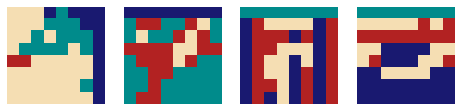

In [431]:
show_fmaps(fmaps,n_clusters=4)

Это изображения соответсвующие этим картам.

In [432]:
fakes = netG(fixed_noise_check)

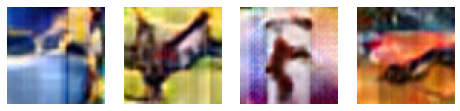

In [433]:
show_imgs(fakes)

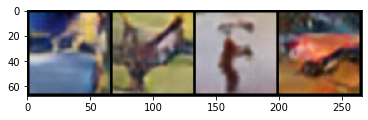

In [434]:
fakes = netG(fixed_noise_check)
vutils.save_image(fakes.detach(),'check_fakes/cifar.png' ,normalize=True)
img = mpimg.imread('check_fakes/cifar.png')
imgplot = plt.imshow(img)
plt.show()

Посмотрим на фичмапы дискриминатора. Они нам понадобятся потом, для сравнения.

In [435]:
fmaps_G = netD.main[:9](fakes)

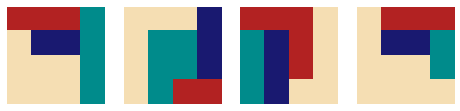

In [436]:
show_fmaps(fmaps_G,n_clusters=4)

Ну кажется, что для CIFAR10 фичмапы генератора выглядят довольно неплохо. При этом они советуют брать ранние карты, а на них и не должно быть сильных деталей. Попробуем обучить ГАН с их регуляризацией. Напомним, что именно предлагают авторы. Это лосс для обычного гана.

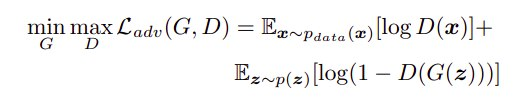

Архетекутра представленная в статье:
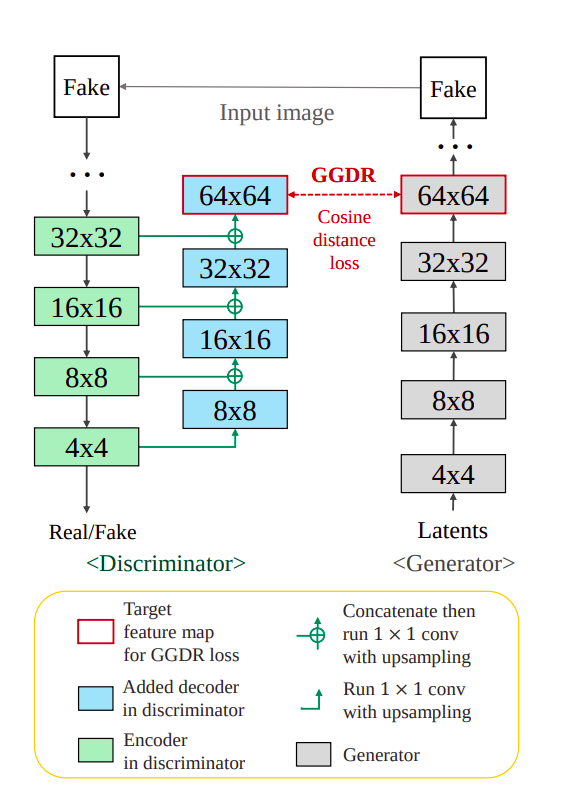

Мы добавляем в нашу уже написанную архетектуру дискриминатора, что-то вроде U-NET. И добаляем в лосс следующую регуляризацию.
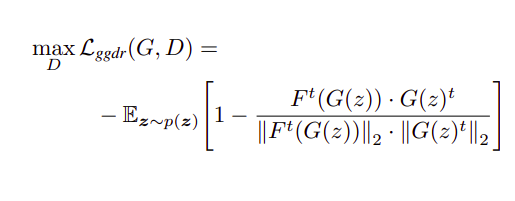

В итоге наш лосс 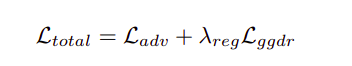

Где \lambda_{reg} -- гиперпараметр, у себя в коде они берут его равным 10. Мы сделем также.

In [372]:
#MODEL
# number of gpu's available
ngpu = 1
# input noise dimension
nz = 100
# number of generator filters
ngf = 64
#number of discriminator filters
ndf = 64
from collections import defaultdict

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator_new(nn.Module):
    def __init__(self, ngpu):
        super(Generator_new, self).__init__()
        self.ngpu = ngpu

        self.layer_1 =  nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),)
        self.layer_2 = nn.Sequential(
             # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
        )
        self.layer_3 = nn.Sequential(
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
        )
        self.layer_4 = nn.Sequential(
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
        )
        self.layer_5 = nn.Sequential(
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
  

    def forward(self, input):
        fmaps = defaultdict(torch.Tensor)
        fmaps["input"] = input
        fmaps["layer_1"] = self.layer_1(fmaps["input"]) #4*4
        fmaps["layer_2"] = self.layer_2(fmaps["layer_1"]) #8*8
        fmaps["layer_3"] = self.layer_3(fmaps["layer_2"]) #16*16
        fmaps["layer_4"] = self.layer_4(fmaps["layer_3"]) #32 * 32
        fmaps["layer_5"] = self.layer_5(fmaps["layer_4"]) #64 * 64
        return fmaps["layer_5"], fmaps

netG = Generator_new(ngpu).to(device)
netG.apply(weights_init)
#load weights to test the model
#netG.load_state_dict(torch.load('weights/netG_epoch_24.pth'))
print(netG)

class Discriminator_new(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator_new, self).__init__()
        self.ngpu = ngpu
        self.encoder_1 = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.encoder_2 = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.encoder_3 = nn.Sequential(
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.encoder_4 = nn.Sequential(
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
        )
        self.encoder_5 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        
        self.decoder_1 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.ConvTranspose2d((ndf*8), (ndf*4), kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.BatchNorm2d(ndf*4)
            # state size. (ndf*4) x 8 x 8
        )
        self.decoder_2 = nn.Sequential(
            # state size. (ndf*8) x 8 x 8
            nn.ConvTranspose2d((ndf*8), (ndf*2), kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.BatchNorm2d(ndf*2)
            #(ndf*2) x 16 x 16
        )
        self.decoder_3 = nn.Sequential(
           # state size. (ndf*4) x 16 x 16
            nn.ConvTranspose2d((ndf*4), (ndf), kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.BatchNorm2d(ndf)
            #(ndf) x 32 x 32
        )
        self.decoder_4 = nn.Sequential(
            # state size. (ndf*2) x 32 x 32
            nn.ConvTranspose2d((ndf*2), (nc), kernel_size=3, stride=2, padding=1, output_padding = 1),
            nn.BatchNorm2d(nc)
            #(nс) x 64 x 64
        )

    def forward(self, input):
        outs = defaultdict(torch.Tensor)
        outs["input"] = input
        outs["encoder_1"] = self.encoder_1(outs["input"])
        outs["encoder_2"] = self.encoder_2(outs["encoder_1"])
        outs["encoder_3"] = self.encoder_3(outs["encoder_2"])
        outs["encoder_4"] = self.encoder_4(outs["encoder_3"])
        outs["encoder_5"] = self.encoder_5(outs["encoder_4"])
        
        feats = defaultdict(torch.Tensor)
        #print(ndf, outs["encoder_4"].shape )
        feats['8*8'] = self.decoder_1(outs["encoder_4"]) #(ndf*4) x 8 x 8
        y = torch.cat([outs["encoder_3"], feats['8*8']], dim = 1) #(ndf*8) x 8 x 8
        feats['16*16'] = self.decoder_2(y)
        y = torch.cat([outs["encoder_2"], feats['16*16']], dim = 1) #(ndf*4) x 16 x 16
        feats['32*32'] = self.decoder_3(y)
        y = torch.cat([outs["encoder_1"], feats['32*32']], dim = 1) #(ndf*2) x 32x 32
        feats['64*64'] = self.decoder_4(y)


        return outs["encoder_5"].view(-1, 1).squeeze(1), feats

netD = Discriminator_new(ngpu).to(device)
netD.apply(weights_init)
#load weights to test the model 
#netD.load_state_dict(torch.load('weights/netD_epoch_24.pth'))
print(netD)




Generator_new(
  (layer_1): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_3): Sequential(
    (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_4): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer_5): Sequential

In [ ]:
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

lambda_reg = 10
niter = 40
g_loss = []
d_loss = []

In [ ]:
#TRAIN
import torch.nn.functional as F
wandb.init(project="HSE_Research_seminar", name='GAN_with_reg')
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output, feats = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake, fmaps = netG(noise)
        label.fill_(fake_label)
        output, feats = netD(fake.detach())
        errD_fake = criterion(output, label)
        #errD_fake.backward()
        D_G_z1 = output.mean().item()
        err_D_reg = lambda_reg * (1 - F.cosine_similarity(feats['8*8'], fmaps["layer_2"]).mean())
        #print(err_D_reg)
        err_plus_reg = errD_fake + err_D_reg
        #err_D_reg.backward()
        err_plus_reg.backward()
        errD = errD_real + errD_fake + err_D_reg
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        fake, fmaps = netG(noise)
        label.fill_(real_label)  # fake labels are real for generator cost
        output, feats = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        wandb.log({"epoch": epoch})
        wandb.log({"Loss_D": errD.item()})
        wandb.log({"Loss_G": errG.item()})

        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'output_2/real_samples.png',normalize=True)
            fake, fmaps = netG(fixed_noise)
            vutils.save_image(fake.detach(),'output_2/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), 'weights_2/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'weights_2/netD_epoch_%d.pth' % (epoch))
wandb.finish()

Loss_D,▁
Loss_G,▁
epoch,▁
Loss_D,11.76497
Loss_G,4.0131
epoch,0


saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the

Loss_D,▄▄▄▄▄▄▅▅█▅▅▄▅▄▄▅▄▆▄▆▅▆▆▅▅▅▅▆▆▅▆▄▂▁▁▁▁▁▁▂
Loss_G,▃▃▃▃▃▃▁▅▅▁▂▃▃▄▃▂▄▃▄▄▂▂▃▃▂▃▃▂▆▃▃▅▆▆██▇▇▇▅
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss_D,0.64946
Loss_G,9.57927
epoch,39


In [437]:
#погружаем чекпоинты
netD = Discriminator_new(ngpu).to(device)
netG = Generator_new(ngpu).to(device)
netD.load_state_dict(torch.load('weights_2/netD_epoch_28.pth'))
netG.load_state_dict(torch.load('weights_2/netG_epoch_28.pth'))
netG.eval();
netD.eval();

Посмотрим на фичмапы у генератора. Они кажутся все еще неплохими. Значит ничего не сломали.

In [438]:
fakes, fmaps = netG(fixed_noise_check)

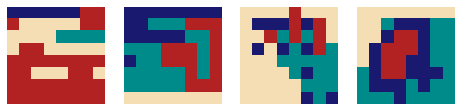

In [439]:
show_fmaps(fmaps['layer_2'],n_clusters=4)

Изображения для этих фичмап.

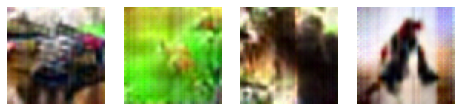

In [440]:
show_imgs(fakes)

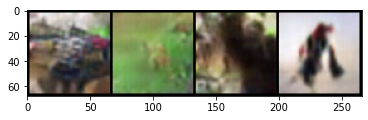

In [441]:
fakes, fmaps = netG(fixed_noise_check)
vutils.save_image(fakes.detach(),'check_fakes/cifar_1.png' ,normalize=True)
img = mpimg.imread('check_fakes/cifar_1.png')
imgplot = plt.imshow(img)
plt.show()

Фичмапы декодера дискрименатора. Авторы их не рисовали, но мне стало интересно. Но в них тоже есть какой-то смысл.

In [442]:
out, feats = netD(fakes)

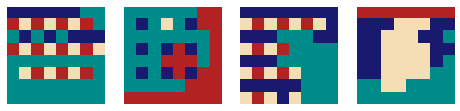

In [443]:
show_fmaps(feats['8*8'],n_clusters=4)

Фичмапы энкодера дискриминатора. Они выглядят уже лучше, чем без регуляризации.

In [444]:
outs = defaultdict(torch.Tensor)
outs["input"] = fakes
outs["encoder_1"] = netD.encoder_1(outs["input"])
outs["encoder_2"] = netD.encoder_2(outs["encoder_1"])
outs["encoder_3"] = netD.encoder_3(outs["encoder_2"])

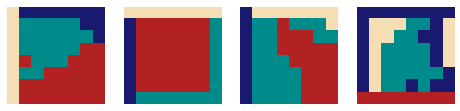

In [445]:
show_fmaps(outs["encoder_3"],n_clusters=4)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!cp -r /content/weights_1 /content/gdrive/MyDrive/HSE_RS_GANS

In [ ]:
!cp -r /content/weights_2 /content/gdrive/MyDrive/HSE_RS_GANS

Попробуем сделать все тоже самое, только с датасетом мультяшных лиц. Тут попробуем взять фичмапы 32*32, они по идеи должны быть более детализированы.

In [252]:
!gsutil cp gs://cartoonset_public_files/cartoonset10k.tgz .

Copying gs://cartoonset_public_files/cartoonset10k.tgz...
| [1 files][454.6 MiB/454.6 MiB]   45.7 MiB/s                                   
Operation completed over 1 objects/454.6 MiB.                                    


In [ ]:
!tar -zxvf cartoonset10k.tgz -C /content/

In [258]:
!rm cartoonset10k/*.csv

rm: cannot remove 'cartoonset10k/*.csv': No such file or directory


In [282]:
!mkdir images
!mv cartoonset10k images/cartoonset10k

In [290]:
train_dataset = dset.ImageFolder('images', transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
]))

In [291]:
dataloader_face = torch.utils.data.DataLoader(train_dataset , batch_size=128,
                                         shuffle=True, num_workers=2)

In [292]:
train_dataset[0][0].shape

torch.Size([3, 64, 64])

In [293]:
netG = Generator(ngpu).to(device)
netG.apply(weights_init);
netD = Discriminator(ngpu).to(device)
netD.apply(weights_init);

In [294]:
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

niter = 40
g_loss = []
d_loss = []

In [295]:
#TRAIN
wandb.init(project="HSE_Research_seminar", name='GAN_without_reg_cartoon')
for epoch in range(niter):
    for i, data in enumerate(dataloader_face, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        wandb.log({"epoch": epoch})
        wandb.log({"Loss_D": errD.item()})
        wandb.log({"Loss_G": errG.item()})

        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'output_cartoon/real_samples.png',normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),'output_cartoon/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), 'weights_cartoon/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'weights_cartoon/netD_epoch_%d.pth' % (epoch))
wandb.finish()

saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output


Loss_D,▁▁▁▁▂▁▁▂▁▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▃▁▁▁▁█▁▁▁▁▁▁▁▁
Loss_G,▇█▄▄▅▄▃▅▃▂▂▄▂▄▁▄▂▃▂▁▃▂▃▂▃▄▆▂▃▃▂▅▃▄▄▃▃▄▄▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss_D,0.07002
Loss_G,4.93091
epoch,39


In [296]:
!cp -r /content/weights_cartoon /content/gdrive/MyDrive/HSE_RS_GANS

In [375]:
netD = Discriminator(ngpu).to(device)
netD.load_state_dict(torch.load('weights_cartoon/netD_epoch_20.pth'))
netG = Generator(ngpu).to(device)
netG.load_state_dict(torch.load('weights_cartoon/netG_epoch_20.pth'))
netG.eval();
netD.eval();

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [355]:
fixed_noise_check = torch.randn(4, nz, 1, 1, device=device)

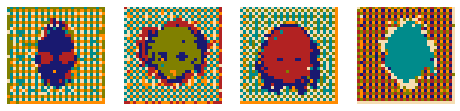

In [356]:
fmaps = netG.main[:12](fixed_noise_check) # 32 * 32
show_fmaps(fmaps,n_clusters=6)

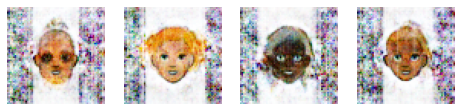

In [357]:
fakes = netG(fixed_noise_check)
show_imgs(fakes)

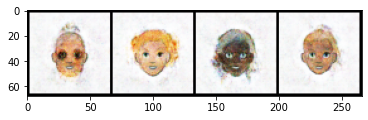

In [377]:
fakes = netG(fixed_noise_check)
vutils.save_image(fakes.detach(),'check_fakes/cartoon.png' ,normalize=True)
img = mpimg.imread('check_fakes/cartoon.png')
imgplot = plt.imshow(img)
plt.show()

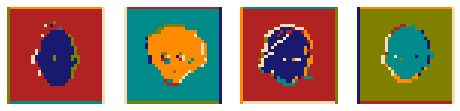

In [358]:
fmaps_G = netD.main[:2](fakes) #32 * 32
show_fmaps(fmaps_G,n_clusters=6)

Обучаем с регуляризацией

In [353]:
netG = Generator_new(ngpu).to(device)
netG.apply(weights_init);
netD = Discriminator_new(ngpu).to(device)
netD.apply(weights_init);

In [330]:
criterion = nn.BCELoss()

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(128, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0

niter = 40
g_loss = []
d_loss = []

In [331]:
#TRAIN
import torch.nn.functional as F
wandb.init(project="HSE_Research_seminar", name='GAN_with_reg_cartoon')
for epoch in range(niter):
    for i, data in enumerate(dataloader_face, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        label = torch.full((batch_size,), real_label, device=device)

        output, feats = netD(real_cpu)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake, fmaps = netG(noise)
        label.fill_(fake_label)
        output, feats = netD(fake.detach())
        errD_fake = criterion(output, label)
        #errD_fake.backward()
        D_G_z1 = output.mean().item()
        err_D_reg = lambda_reg * (1 - F.cosine_similarity(feats['32*32'], fmaps["layer_4"]).mean())
        #print(err_D_reg)
        err_plus_reg = errD_fake + err_D_reg
        #err_D_reg.backward()
        err_plus_reg.backward()
        errD = errD_real + errD_fake + err_D_reg
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        fake, fmaps = netG(noise)
        label.fill_(real_label)  # fake labels are real for generator cost
        output, feats = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        #print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' % (epoch, niter, i, len(dataloader), errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        wandb.log({"epoch": epoch})
        wandb.log({"Loss_D": errD.item()})
        wandb.log({"Loss_G": errG.item()})

        #save the output
        if i % 100 == 0:
            print('saving the output')
            vutils.save_image(real_cpu,'output_cartoon_1/real_samples.png',normalize=True)
            fake, fmaps = netG(fixed_noise)
            vutils.save_image(fake.detach(),'output_cartoon_1/fake_samples_epoch_%03d.png' % (epoch),normalize=True)
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), 'weights_cartoon_1/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), 'weights_cartoon_1/netD_epoch_%d.pth' % (epoch))
wandb.finish()

saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output
saving the output


Loss_D,█▄▂▁▂▁▁▁▁▁▁▅▄▃▄▃▄▃▃▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▂▂▃▂▂▂
Loss_G,▃██████████▂▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂▂▂▂▂▁▁▂
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Loss_D,0.90281
Loss_G,5.8443
epoch,39


In [332]:
!cp -r /content/weights_cartoon_1 /content/gdrive/MyDrive/HSE_RS_GANS

Рисуем фичмапы.

In [365]:
netD = Discriminator_new(ngpu).to(device)
netG = Generator_new(ngpu).to(device)
netD.load_state_dict(torch.load('weights_cartoon_1/netD_epoch_39.pth'))
netG.load_state_dict(torch.load('weights_cartoon_1/netG_epoch_39.pth'))
netG.eval();
netD.eval();

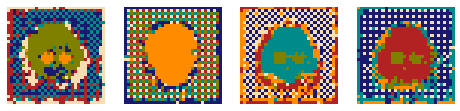

In [361]:
fakes, fmaps = netG(fixed_noise_check)
show_fmaps(fmaps['layer_4'],n_clusters=6)

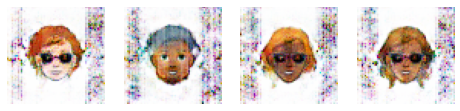

In [362]:
show_imgs(fakes)

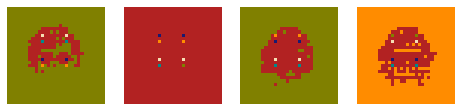

In [363]:
out, feats = netD(fakes)
show_fmaps(feats['32*32'], n_clusters=6)

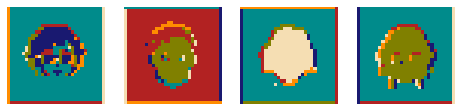

In [364]:
outs = defaultdict(torch.Tensor)
outs["input"] = fakes
outs["encoder_1"] = netD.encoder_1(outs["input"])
show_fmaps(outs["encoder_1"], n_clusters=6)

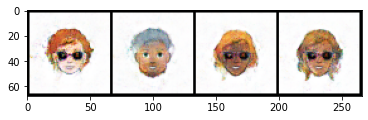

In [370]:
fakes, fmaps = netG(fixed_noise_check)
vutils.save_image(fakes.detach(),'check_fakes/cartoon_1.png' ,normalize=True)
img = mpimg.imread('check_fakes/cartoon_1.png')
imgplot = plt.imshow(img)
plt.show()

Вывод:

https://wandb.ai/marina_shesha/HSE_Research_seminar?workspace=user-marina_shesha -- логи в вандб

Если посмотреть на обучение второго датасета, то можно увидеть, что регуляризация дествительно работает, ГАН не переобучился к 40-ой эпохе, чего нельзя сказать о ГАНе без регуляризации.

Кроме того, несмотря на то, что датасеты небольшие действительно на датасете с игрушечными лицами, как мне кажется качество чуть получше (визуально). 

Также на cifar10 хорошо видно, что с регуляризацией фичмапы у дикриминатора улвливают расположение объекта, а без регуляризации не особо.

На обоих датасетах видно, что фичмапы генератора отражают расположения оъекта и даже где-то более детализированную информацию.